In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for AWS compute node


No vtk
File does not exist: /shared/CSHL_data_processed/MD635/MD635_anchor.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_sorted_filenames.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD657/MD657_anchor.txt
File does not exist: /shared/CSHL_data_processed/MD657/MD657_sorted_filenames.txt
File does not exist: /shared/CSHL_data_processed/MD657/MD657_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD657/MD657_cropbox.txt


In [3]:
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier 

sys.path.append('/home/yuncong/csd395/xgboost/python-package')
try:
    from xgboost.sklearn import XGBClassifier
except:
    sys.stderr.write('xgboost is not loaded.')

xgboost is not loaded.

In [4]:
# structures_to_sample = all_known_structures

# negative_labels_to_sample = [s + '_negative' for s in structures_to_sample]

# margins_to_sample = [500] # (200: 100 um, 500: 250 um)
# surround_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix=surr_l) 
#                              for m in margins_to_sample
#                              for s in structures_to_sample 
#                              for surr_l in structures_to_sample + ['noclass'] 
#                              if surr_l != s]

# labels_to_sample = structures_to_sample + negative_labels_to_sample + surround_labels_to_sample + ['noclass']

# Train Classifiers

In [5]:
classifier_settings

,model,margin,train_set_id,neg_composition,sample_weighting
classifier_id,,,,,
30,lr,500,20/21,neg_has_all_surround,NaN
31,lr,500,21/22,neg_has_all_surround,NaN
32,lr,500,20/22,neg_has_all_surround,NaN
33,gb1,500,20/21,neg_has_all_surround,NaN
34,gb1,500,21/22,neg_has_all_surround,NaN
35,gb1,500,20/22,neg_has_all_surround,NaN


In [6]:
classifier_id = 33
classifier_properties = classifier_settings.loc[classifier_id]

margin = classifier_properties['margin']
model = classifier_properties['model']
sample_weighting = classifier_properties['sample_weighting']
neg_composition = classifier_properties['neg_composition']

In [7]:
# Determine which labels to load.

structures_to_sample = all_known_structures
negative_labels_to_sample = [s + '_negative' for s in structures_to_sample]

margins_to_sample = [margin] # (200: 100 um, 500: 250 um)
surround_positive_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix=surr_l) 
                             for m in margins_to_sample
                             for s in structures_to_sample 
                             for surr_l in structures_to_sample
                             if surr_l != s]
surround_noclass_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix='noclass') 
                             for m in margins_to_sample
                             for s in structures_to_sample]

if neg_composition == 'neg_has_everything_else':
    labels_to_sample = structures_to_sample + negative_labels_to_sample
elif neg_composition == 'neg_has_only_surround_noclass':
    labels_to_sample = structures_to_sample + surround_noclass_labels_to_sample + ['noclass']
elif neg_composition == 'neg_has_all_surround':
    labels_to_sample = structures_to_sample + surround_positive_labels_to_sample + surround_noclass_labels_to_sample + ['noclass']

In [8]:
# Load training dataset.

training_set_ids = map(int, str(classifier_properties['train_set_id']).split('/'))
training_features, training_addresses = load_datasets(training_set_ids, labels_to_sample=labels_to_sample)
    
assert set(training_addresses.keys()) == set(training_features.keys()), \
    'Training features and training addresses are not consistent.'

rm -rf /shared/CSHL_classifiers/datasets/dataset_20/patch_addresses.pkl && mkdir -p /shared/CSHL_classifiers/datasets/dataset_20
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_20/patch_addresses.pkl /shared/CSHL_classifiers/datasets/dataset_20/patch_addresses.pkl


Child returned 0
Child returned 0
0.62 seconds.


rm -rf /shared/CSHL_classifiers/datasets/dataset_20/patch_features.hdf && mkdir -p /shared/CSHL_classifiers/datasets/dataset_20
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_20/patch_features.hdf /shared/CSHL_classifiers/datasets/dataset_20/patch_features.hdf


Child returned 0
Child returned 0
1.53 seconds.


rm -rf /shared/CSHL_classifiers/datasets/dataset_21/patch_addresses.pkl && mkdir -p /shared/CSHL_classifiers/datasets/dataset_21
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_21/patch_addresses.pkl /shared/CSHL_classifiers/datasets/dataset_21/patch_addresses.pkl


Child returned 0
Child returned 0
0.54 seconds.


rm -rf /shared/CSHL_classifiers/datasets/dataset_21/patch_features.hdf && mkdir -p /shared/CSHL_classifiers/datasets/dataset_21
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_21/patch_features.hdf /shared/CSHL_classifiers/datasets/dataset_21/patch_features.hdf


Child returned 0
Child returned 0
1.50 seconds.


In [9]:
labels_found = training_features.keys()
structures_found = set([convert_to_original_name(l) for l in labels_found]) - {'noclass'}

In [10]:
setting_dir = os.path.join(os.path.join(CLF_ROOTDIR, 'setting_%d' % classifier_id))

In [11]:
clf_dir = create_if_not_exists(os.path.join(setting_dir, 'classifiers'))

for structure in structures_found:

    print structure
    
    #############################
    ## Define Positive Samples ##
    #############################
    
    features_pos = training_features[structure]
    n_pos = len(features_pos)
    
    #############################
    ## Define Negative Samples ##
    #############################
    
#     if setting in [1, 3, 4, 5, 6, 7]:
    if neg_composition == 'neg_has_only_surround_noclass':
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
#     elif setting in [2, 10, 23, 24, 25, 26]:
    elif neg_composition == 'neg_has_all_surround':
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
        for surr_s in structures_found:
            c = convert_to_surround_name(structure, margin=margin, suffix=surr_s)
            if c in labels_found:
                neg_classes.append(c)
#     elif setting in [8,9,11]:
    elif neg_composition == 'neg_has_everything_else':
        neg_classes = [structure + '_negative']
    else:
        raise Exception('neg_composition %s is not recognized.' % neg_composition)

    features_neg = np.concatenate([training_features[neg_class] for neg_class in neg_classes])
        
    n_neg = len(features_neg)
        
    ###########################
    ## Define Sample Weights ##
    ###########################
    
#     if setting == 9:
    if sample_weighting == 'weighted':
        neg_distances = np.concatenate([distances_to_structures[neg_class][structure] for neg_class in neg_classes])
            
        sample_weights_neg = np.ones((n_neg,))
        sample_weights_neg[neg_distances > thresh] = diminishing(neg_distances[neg_distances > thresh])
        sample_weights = np.r_[np.ones((n_pos,)), sample_weights_neg]
    else:
        sample_weights = None
    
    ###########################################################################################

    train_data = np.r_[features_pos, features_neg]
    train_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
#     n_train = len(train_labels0)
#     ri = np.random.choice(range(n_train), size=100, replace=False)
#     train_data = train_data0[ri]
#     train_labels = train_labels0[ri]
    
    ##################
    ## Define Model ##
    ##################
    
#     if setting in [1, 2, 8, 9, 10, 11, 23, 24]:
    if model == 'lr':
        clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, 
                                 fit_intercept=True, intercept_scaling=1, class_weight=None, 
                                 random_state=None, solver='liblinear', max_iter=100, multi_class='ovr', 
                                 verbose=0, warm_start=False, n_jobs=1)
            
#     elif setting == 3:
    elif model == 'lin_svc':
        clf = SVC(C=1.0, kernel='linear', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
                  probability=True, tol=0.001, cache_size=1000, max_iter=-1,
              decision_function_shape=None, random_state=None)
        

#     elif setting == 4:
    elif model == 'lin_svc_calib':
        
        sv_uncalibrated = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, 
                                C=1.0, multi_class='ovr', 
                                fit_intercept=True, intercept_scaling=1, max_iter=100)
        clf = CalibratedClassifierCV(sv_uncalibrated)
        
        
#     elif setting in [5]:        
    elif model == 'xgb1':
        clf = XGBClassifier(max_depth=3, learning_rate=0.2, n_estimators=200, 
                            silent=False, objective='binary:logistic', nthread=-1, gamma=0, 
                            min_child_weight=20, max_delta_step=0, subsample=.8, 
                            colsample_bytree=.8, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                            scale_pos_weight=1, base_score=0.5, seed=0, missing=None)
        
#     elif setting in [6, 25]:
    elif model == 'gb1':
        clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=200, 
                                         subsample=1., criterion='friedman_mse', 
                                         min_samples_split=50, min_samples_leaf=20, 
                                         min_weight_fraction_leaf=0.0, max_depth=3, 
                                         min_impurity_split=1e-07, init=None, random_state=None, 
                                         max_features=None, verbose=1, max_leaf_nodes=None, 
                                         warm_start=False, presort='auto')
        
#     elif setting in [7, 26]:     
    elif model == 'gb2':
        clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=100, 
                                         subsample=1., criterion='friedman_mse', 
                                         min_samples_split=50, min_samples_leaf=20, 
                                         min_weight_fraction_leaf=0.0, max_depth=5, 
                                         min_impurity_split=1e-07, init=None, random_state=None, 
                                         max_features=None, verbose=1, max_leaf_nodes=None, 
                                         warm_start=False, presort='auto')
        
    
    else:
        sys.stderr.write('Setting is not recognized.\n')

    
    t = time.time()    
    clf.fit(train_data, train_labels, sample_weight=sample_weights)
    sys.stderr.write('Fitting classifier: %.2f seconds\n' % (time.time() - t))

    clf_fp = os.path.join(clf_dir, '%(structure)s_clf_setting_%(setting)d.dump' % \
                                  dict(structure=structure, setting=classifier_id))
    
    joblib.dump(clf, clf_fp)
    
    upload_from_ec2_to_s3(clf_fp)

Tz
      Iter       Train Loss   Remaining Time 
         1           1.1062            1.06m
         2           0.9608            1.06m
         3           0.8632            1.06m
         4           0.7888            1.05m
         5           0.7305            1.05m
         6           0.6861            1.05m
         7           0.6490            1.04m
         8           0.6156            1.04m
         9           0.5883            1.04m
        10           0.5632            1.04m
        20           0.4094           58.36s
        30           0.3218           54.48s
        40           0.2653           50.70s
        50           0.2236           46.91s
        60           0.1870           43.50s
        70           0.1617           40.08s
        80           0.1393           36.94s
        90           0.1203           33.69s
       100           0.1013           30.80s
       200           0.0223            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_33/class

Fitting classifier: 61.92 seconds
Child returned 0
0.44 seconds.


Sp5O
      Iter       Train Loss   Remaining Time 
         1           1.1878            1.48m
         2           1.1292            1.45m
         3           1.0822            1.43m
         4           1.0472            1.43m
         5           1.0169            1.42m
         6           0.9908            1.41m
         7           0.9726            1.39m
         8           0.9542            1.39m
         9           0.9382            1.38m
        10           0.9213            1.36m
        20           0.8190            1.27m
        30           0.7665            1.17m
        40           0.7184            1.08m
        50           0.6627            1.02m
        60           0.6174           56.79s
        70           0.5751           52.67s
        80           0.5423           48.34s
        90           0.5042           44.34s
       100           0.4713           40.27s
       200           0.2501            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_33/cla

Fitting classifier: 81.07 seconds
Child returned 0
0.49 seconds.


7n
      Iter       Train Loss   Remaining Time 
         1           1.0636           53.16s
         2           0.8719           52.53s
         3           0.7436           52.15s
         4           0.6551           51.87s
         5           0.5891           51.57s
         6           0.5369           51.41s
         7           0.4972           51.15s
         8           0.4665           51.04s
         9           0.4426           50.63s
        10           0.4250           50.24s
        20           0.3161           46.52s
        30           0.2541           43.14s
        40           0.2123           39.87s
        50           0.1800           36.90s
        60           0.1496           34.29s
        70           0.1235           31.85s
        80           0.1033           29.32s
        90           0.0850           26.96s
       100           0.0717           24.52s
       200           0.0151            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_33/class

Fitting classifier: 49.34 seconds
Child returned 0
0.44 seconds.


DC
      Iter       Train Loss   Remaining Time 
         1           1.0081            1.97m
         2           0.9364            1.96m
         3           0.8860            1.96m
         4           0.8430            1.96m
         5           0.8068            1.95m
         6           0.7822            1.92m
         7           0.7583            1.91m
         8           0.7310            1.91m
         9           0.7129            1.90m
        10           0.6960            1.88m
        20           0.5672            1.77m
        30           0.4789            1.66m
        40           0.4191            1.57m
        50           0.3733            1.46m
        60           0.3350            1.36m
        70           0.3029            1.26m
        80           0.2751            1.16m
        90           0.2496            1.06m
       100           0.2327           57.64s
       200           0.0965            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_33/class

Fitting classifier: 115.51 seconds
Child returned 0
0.44 seconds.


5N
      Iter       Train Loss   Remaining Time 
         1           1.1539           53.33s
         2           1.0205           52.35s
         3           0.9308           51.81s
         4           0.8690           51.42s
         5           0.8196           51.21s
         6           0.7811           51.02s
         7           0.7502           50.59s
         8           0.7247           50.15s
         9           0.6991           50.00s
        10           0.6754           49.82s
        20           0.5336           47.06s
        30           0.4543           42.69s
        40           0.3887           39.75s
        50           0.3325           37.07s
        60           0.2853           34.52s
        70           0.2476           31.95s
        80           0.2154           29.38s
        90           0.1877           26.82s
       100           0.1614           24.43s
       200           0.0480            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_33/class

Fitting classifier: 48.58 seconds
Child returned 0
0.44 seconds.


RtTg
      Iter       Train Loss   Remaining Time 
         1           1.1799            1.56m
         2           1.1385            1.55m
         3           1.0965            1.55m
         4           1.0664            1.52m
         5           1.0412            1.51m
         6           1.0192            1.49m
         7           1.0005            1.47m
         8           0.9822            1.46m
         9           0.9631            1.46m
        10           0.9478            1.45m
        20           0.8310            1.35m
        30           0.7512            1.27m
        40           0.6952            1.19m
        50           0.6466            1.11m
        60           0.6003            1.03m
        70           0.5599           57.11s
        80           0.5255           52.61s
        90           0.4942           47.97s
       100           0.4609           43.66s
       200           0.2486            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_33/cla

Fitting classifier: 87.79 seconds
Child returned 0
0.44 seconds.


Pn
      Iter       Train Loss   Remaining Time 
         1           1.0953            1.47m
         2           0.9889            1.45m
         3           0.9189            1.43m
         4           0.8648            1.41m
         5           0.8205            1.41m
         6           0.7851            1.40m
         7           0.7570            1.38m
         8           0.7338            1.37m
         9           0.7134            1.37m
        10           0.6945            1.37m
        20           0.5650            1.29m
        30           0.4865            1.20m
        40           0.4244            1.13m
        50           0.3756            1.06m
        60           0.3330           59.08s
        70           0.2981           54.68s
        80           0.2678           50.39s
        90           0.2396           46.07s
       100           0.2165           41.76s
       200           0.0756            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_33/class

Fitting classifier: 84.17 seconds
Child returned 0
0.44 seconds.


10N
      Iter       Train Loss   Remaining Time 
         1           0.9793            1.40m
         2           0.8305            1.38m
         3           0.7366            1.38m
         4           0.6614            1.37m
         5           0.6120            1.35m
         6           0.5650            1.35m
         7           0.5319            1.34m
         8           0.5015            1.34m
         9           0.4778            1.33m
        10           0.4563            1.32m
        20           0.3333            1.25m
        30           0.2661            1.17m
        40           0.2189            1.10m
        50           0.1857            1.02m
        60           0.1568           57.19s
        70           0.1338           52.96s
        80           0.1108           48.87s
        90           0.0950           44.79s
       100           0.0808           40.72s
       200           0.0208            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_33/clas

Fitting classifier: 81.40 seconds
Child returned 0
0.49 seconds.


LC
      Iter       Train Loss   Remaining Time 
         1           1.1719           53.21s
         2           1.0425           51.96s
         3           0.9449           52.01s
         4           0.8771           51.62s
         5           0.8284           51.25s
         6           0.7898           50.91s
         7           0.7564           50.57s
         8           0.7294           50.11s
         9           0.7038           49.97s
        10           0.6839           49.80s
        20           0.5532           45.52s
        30           0.4601           42.85s
        40           0.3994           39.63s
        50           0.3455           37.00s
        60           0.2977           34.43s
        70           0.2578           31.93s
        80           0.2204           29.52s
        90           0.1903           27.04s
       100           0.1643           24.56s
       200           0.0447            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_33/class

Fitting classifier: 49.38 seconds
Child returned 0
0.44 seconds.


7N
      Iter       Train Loss   Remaining Time 
         1           1.1981           53.48s
         2           1.0788           52.26s
         3           0.9901           51.57s
         4           0.9254           51.45s
         5           0.8744           51.35s
         6           0.8267           51.30s
         7           0.7884           51.15s
         8           0.7585           50.98s
         9           0.7322           50.75s
        10           0.7131           50.51s
        20           0.5663           47.11s
        30           0.4867           42.98s
        40           0.4170           39.87s
        50           0.3641           36.89s
        60           0.3145           34.13s
        70           0.2779           31.46s
        80           0.2420           29.07s
        90           0.2126           26.51s
       100           0.1897           23.98s
       200           0.0543            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_33/class

Fitting classifier: 48.43 seconds
Child returned 0
0.44 seconds.


Amb
      Iter       Train Loss   Remaining Time 
         1           0.9373           39.01s
         2           0.7654           38.19s
         3           0.6518           37.69s
         4           0.5626           37.60s
         5           0.5032           37.30s
         6           0.4544           37.10s
         7           0.4185           37.05s
         8           0.3907           36.85s
         9           0.3646           36.65s
        10           0.3415           36.48s
        20           0.2164           34.21s
        30           0.1550           32.07s
        40           0.1146           29.73s
        50           0.0838           28.01s
        60           0.0647           25.89s
        70           0.0505           23.98s
        80           0.0404           22.00s
        90           0.0319           20.03s
       100           0.0245           18.22s
       200           0.0025            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_33/clas

Fitting classifier: 36.33 seconds
Child returned 0
0.45 seconds.


12N
      Iter       Train Loss   Remaining Time 
         1           1.0160            1.35m
         2           0.8664            1.32m
         3           0.7580            1.32m
         4           0.6780            1.31m
         5           0.6185            1.30m
         6           0.5775            1.30m
         7           0.5400            1.30m
         8           0.5084            1.29m
         9           0.4825            1.29m
        10           0.4612            1.29m
        20           0.3363            1.21m
        30           0.2762            1.13m
        40           0.2325            1.05m
        50           0.1940           58.99s
        60           0.1638           54.97s
        70           0.1398           50.84s
        80           0.1198           46.82s
        90           0.1025           42.92s
       100           0.0892           38.99s
       200           0.0242            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_33/clas

Fitting classifier: 77.70 seconds
Child returned 0
0.44 seconds.


RMC
      Iter       Train Loss   Remaining Time 
         1           1.2248           53.15s
         2           1.1291           51.71s
         3           1.0627           51.33s
         4           1.0155           51.00s
         5           0.9777           51.09s
         6           0.9446           51.06s
         7           0.9173           50.78s
         8           0.8941           49.51s
         9           0.8720           48.86s
        10           0.8524           48.49s
        20           0.7111           44.84s
        30           0.6177           41.11s
        40           0.5467           37.96s
        50           0.4937           35.13s
        60           0.4422           32.73s
        70           0.3960           30.21s
        80           0.3533           27.84s
        90           0.3199           25.41s
       100           0.2909           23.00s
       200           0.1040            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_33/clas

Fitting classifier: 46.13 seconds
Child returned 0
0.45 seconds.


VCA
      Iter       Train Loss   Remaining Time 
         1           0.9709            1.92m
         2           0.8766            1.92m
         3           0.8142            1.91m
         4           0.7701            1.90m
         5           0.7347            1.89m
         6           0.7066            1.89m
         7           0.6807            1.88m
         8           0.6587            1.87m
         9           0.6416            1.85m
        10           0.6249            1.83m
        20           0.5210            1.73m
        30           0.4621            1.61m
        40           0.4102            1.51m
        50           0.3709            1.40m
        60           0.3349            1.31m
        70           0.3021            1.22m
        80           0.2742            1.12m
        90           0.2482            1.03m
       100           0.2269           55.75s
       200           0.0964            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_33/clas

Fitting classifier: 111.54 seconds
Child returned 0
0.44 seconds.


Sp5I
      Iter       Train Loss   Remaining Time 
         1           1.0006            1.96m
         2           0.9404            1.97m
         3           0.8920            1.97m
         4           0.8519            1.96m
         5           0.8234            1.95m
         6           0.8008            1.95m
         7           0.7855            1.94m
         8           0.7719            1.92m
         9           0.7583            1.91m
        10           0.7470            1.90m
        20           0.6720            1.75m
        30           0.6155            1.63m
        40           0.5637            1.52m
        50           0.5245            1.43m
        60           0.4849            1.33m
        70           0.4558            1.23m
        80           0.4271            1.12m
        90           0.3977            1.02m
       100           0.3685           54.96s
       200           0.1918            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_33/cla

Fitting classifier: 103.59 seconds
Child returned 0
0.49 seconds.


Sp5C
      Iter       Train Loss   Remaining Time 
         1           1.1313            1.27m
         2           1.0548            1.24m
         3           1.0030            1.24m
         4           0.9628            1.24m
         5           0.9280            1.22m
         6           0.9028            1.20m
         7           0.8822            1.19m
         8           0.8633            1.19m
         9           0.8467            1.17m
        10           0.8323            1.17m
        20           0.7304            1.07m
        30           0.6618           59.31s
        40           0.6002           55.44s
        50           0.5503           51.64s
        60           0.5027           48.35s
        70           0.4636           44.62s
        80           0.4280           41.18s
        90           0.3955           37.63s
       100           0.3687           34.12s
       200           0.1697            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_33/cla

Fitting classifier: 69.38 seconds
Child returned 0
0.44 seconds.


4N
      Iter       Train Loss   Remaining Time 
         1           0.4782           29.70s
         2           0.4076           29.13s
         3           0.3537           28.72s
         4           0.3201           28.12s
         5           0.2975           27.55s
         6           0.2712           27.53s
         7           0.2463           28.04s
         8           0.2273           27.63s
         9           0.2112           27.49s
        10           0.1962           27.57s
        20           0.1204           26.27s
        30           0.0793           24.34s
        40           0.0548           22.69s
        50           0.0367           21.25s
        60           0.0258           19.97s
        70           0.0180           18.48s
        80           0.0132           16.98s
        90           0.0099           15.47s
       100           0.0070           14.02s
       200           0.0003            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_33/class

Fitting classifier: 28.11 seconds
Child returned 0
0.44 seconds.


AP
      Iter       Train Loss   Remaining Time 
         1           1.0140           53.48s
         2           0.8017           51.95s
         3           0.6687           50.85s
         4           0.5726           50.32s
         5           0.5032           49.88s
         6           0.4517           49.51s
         7           0.4123           49.33s
         8           0.3815           48.80s
         9           0.3544           48.52s
        10           0.3320           48.37s
        20           0.2120           45.61s
        30           0.1512           43.17s
        40           0.1132           39.53s
        50           0.0849           36.60s
        60           0.0643           33.95s
        70           0.0509           31.17s
        80           0.0397           28.88s
        90           0.0310           26.41s
       100           0.0245           24.11s
       200           0.0027            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_33/class

Fitting classifier: 47.89 seconds
Child returned 0
0.44 seconds.


PBG
      Iter       Train Loss   Remaining Time 
         1           1.0564           46.56s
         2           0.8739           45.87s
         3           0.7494           45.50s
         4           0.6595           45.16s
         5           0.6020           44.91s
         6           0.5492           44.69s
         7           0.5099           44.57s
         8           0.4702           44.53s
         9           0.4464           44.25s
        10           0.4280           44.03s
        20           0.3019           41.32s
        30           0.2307           37.98s
        40           0.1871           34.90s
        50           0.1503           32.67s
        60           0.1198           30.50s
        70           0.1002           28.08s
        80           0.0799           25.90s
        90           0.0668           23.62s
       100           0.0550           21.45s
       200           0.0093            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_33/clas

Fitting classifier: 42.97 seconds
Child returned 0
0.39 seconds.


LRt
      Iter       Train Loss   Remaining Time 
         1           1.2215           52.48s
         2           1.1156           51.86s
         3           1.0249           51.30s
         4           0.9615           50.57s
         5           0.9137           50.29s
         6           0.8703           49.83s
         7           0.8351           49.52s
         8           0.8045           49.34s
         9           0.7825           48.05s
        10           0.7601           47.87s
        20           0.6180           44.23s
        30           0.5242           40.60s
        40           0.4535           37.79s
        50           0.3986           34.94s
        60           0.3503           32.32s
        70           0.3090           29.86s
        80           0.2717           27.54s
        90           0.2380           25.23s
       100           0.2114           22.87s
       200           0.0655            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_33/clas

Fitting classifier: 45.71 seconds
Child returned 0
0.44 seconds.


IC
      Iter       Train Loss   Remaining Time 
         1           1.1810            1.32m
         2           1.1164            1.28m
         3           1.0708            1.27m
         4           1.0326            1.25m
         5           1.0011            1.24m
         6           0.9710            1.23m
         7           0.9487            1.21m
         8           0.9313            1.20m
         9           0.9144            1.18m
        10           0.8961            1.17m
        20           0.7781            1.09m
        30           0.7063            1.01m
        40           0.6476           56.07s
        50           0.5974           52.28s
        60           0.5507           48.55s
        70           0.5091           45.07s
        80           0.4707           41.58s
        90           0.4404           37.83s
       100           0.4101           34.29s
       200           0.2074            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_33/class

Fitting classifier: 68.42 seconds
Child returned 0
0.44 seconds.


VLL
      Iter       Train Loss   Remaining Time 
         1           1.1597           50.38s
         2           1.0220           49.27s
         3           0.9250           49.14s
         4           0.8527           48.87s
         5           0.7990           48.56s
         6           0.7587           48.19s
         7           0.7298           47.70s
         8           0.7012           47.55s
         9           0.6794           47.43s
        10           0.6598           47.02s
        20           0.5215           44.70s
        30           0.4452           40.57s
        40           0.3792           37.87s
        50           0.3210           35.13s
        60           0.2815           32.71s
        70           0.2441           30.27s
        80           0.2095           27.96s
        90           0.1839           25.47s
       100           0.1606           23.09s
       200           0.0451            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_33/clas

Fitting classifier: 46.17 seconds
Child returned 0
0.49 seconds.


VCP
      Iter       Train Loss   Remaining Time 
         1           0.9945            1.70m
         2           0.9095            1.70m
         3           0.8541            1.63m
         4           0.8015            1.65m
         5           0.7701            1.67m
         6           0.7405            1.67m
         7           0.7193            1.63m
         8           0.6982            1.62m
         9           0.6802            1.61m
        10           0.6640            1.61m
        20           0.5659            1.51m
        30           0.5043            1.39m
        40           0.4562            1.30m
        50           0.4095            1.24m
        60           0.3724            1.14m
        70           0.3422            1.05m
        80           0.3117           58.00s
        90           0.2871           53.07s
       100           0.2663           48.16s
       200           0.1212            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_33/clas

Fitting classifier: 97.04 seconds
Child returned 0
0.49 seconds.


SNC
      Iter       Train Loss   Remaining Time 
         1           1.0913            1.26m
         2           0.9864            1.22m
         3           0.9110            1.22m
         4           0.8513            1.19m
         5           0.8056            1.19m
         6           0.7714            1.19m
         7           0.7429            1.19m
         8           0.7177            1.18m
         9           0.6988            1.18m
        10           0.6774            1.18m
        20           0.5508            1.10m
        30           0.4705            1.02m
        40           0.4145           56.02s
        50           0.3717           51.57s
        60           0.3340           47.63s
        70           0.2993           43.84s
        80           0.2670           40.61s
        90           0.2389           37.14s
       100           0.2158           33.66s
       200           0.0845            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_33/clas

Fitting classifier: 66.53 seconds
Child returned 0
1.01 seconds.


6N
      Iter       Train Loss   Remaining Time 
         1           0.6789           28.71s
         2           0.5683           28.34s
         3           0.4917           28.10s
         4           0.4332           28.28s
         5           0.3847           28.50s
         6           0.3497           28.94s
         7           0.3224           28.90s
         8           0.2970           28.87s
         9           0.2783           28.64s
        10           0.2553           28.79s
        20           0.1597           26.61s
        30           0.0990           25.53s
        40           0.0636           24.06s
        50           0.0457           22.34s
        60           0.0330           20.83s
        70           0.0229           19.38s
        80           0.0169           17.81s
        90           0.0126           16.29s
       100           0.0099           14.74s
       200           0.0018            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_33/class

Fitting classifier: 29.05 seconds
Child returned 0
0.44 seconds.


SNR
      Iter       Train Loss   Remaining Time 
         1           1.1277            1.32m
         2           1.0347            1.30m
         3           0.9697            1.29m
         4           0.9169            1.28m
         5           0.8762            1.27m
         6           0.8432            1.25m
         7           0.8176            1.25m
         8           0.7955            1.23m
         9           0.7730            1.22m
        10           0.7559            1.21m
        20           0.6290            1.13m
        30           0.5558            1.03m
        40           0.4918           58.35s
        50           0.4445           54.05s
        60           0.4031           49.92s
        70           0.3677           46.17s
        80           0.3344           42.48s
        90           0.3023           39.13s
       100           0.2793           35.36s
       200           0.1131            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_33/clas

Fitting classifier: 71.24 seconds
Child returned 0
0.44 seconds.


SC
      Iter       Train Loss   Remaining Time 
         1           1.1950            1.28m
         2           1.1496            1.24m
         3           1.1167            1.25m
         4           1.0894            1.24m
         5           1.0683            1.22m
         6           1.0479            1.22m
         7           1.0303            1.20m
         8           1.0168            1.18m
         9           1.0041            1.16m
        10           0.9918            1.15m
        20           0.8979            1.04m
        30           0.8275           58.22s
        40           0.7738           54.23s
        50           0.7210           50.48s
        60           0.6806           46.53s
        70           0.6434           43.20s
        80           0.6010           39.92s
        90           0.5644           36.57s
       100           0.5272           33.32s
       200           0.2856            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_33/class

Fitting classifier: 67.76 seconds
Child returned 0
0.55 seconds.


3N
      Iter       Train Loss   Remaining Time 
         1           1.1771           51.92s
         2           1.0426           50.97s
         3           0.9495           50.47s
         4           0.8786           50.12s
         5           0.8195           49.59s
         6           0.7763           49.46s
         7           0.7353           48.85s
         8           0.7051           48.63s
         9           0.6801           48.42s
        10           0.6570           48.14s
        20           0.4999           43.73s
        30           0.4076           40.10s
        40           0.3430           37.07s
        50           0.2935           34.71s
        60           0.2471           32.32s
        70           0.2137           29.75s
        80           0.1801           27.59s
        90           0.1560           25.16s
       100           0.1336           22.82s
       200           0.0348            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_33/class

Fitting classifier: 45.03 seconds
Child returned 0
0.44 seconds.


# Load pre-computed classifiers, measure training accuracy

In [12]:
classifier_id = 33

In [13]:
clf_allClasses = {}
for structure in structures_to_sample:
    clf_fp = os.path.join(setting_dir, 'classifiers', '%(structure)s_clf_setting_%(setting)d.dump' % {'structure': structure, 'setting':classifier_id})
    download_from_s3_to_ec2(clf_fp)
    if os.path.exists(clf_fp):
        clf_allClasses[structure] = joblib.load(clf_fp)
    else:
        sys.stderr.write('Classifier for %s is not found.\n' % structure)

Child returned 0


rm -rf /shared/CSHL_classifiers/setting_33/classifiers/5N_clf_setting_33.dump && mkdir -p /shared/CSHL_classifiers/setting_33/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_33/classifiers/5N_clf_setting_33.dump /shared/CSHL_classifiers/setting_33/classifiers/5N_clf_setting_33.dump


Child returned 0
0.51 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_33/classifiers/6N_clf_setting_33.dump && mkdir -p /shared/CSHL_classifiers/setting_33/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_33/classifiers/6N_clf_setting_33.dump /shared/CSHL_classifiers/setting_33/classifiers/6N_clf_setting_33.dump


Child returned 0
0.51 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_33/classifiers/7N_clf_setting_33.dump && mkdir -p /shared/CSHL_classifiers/setting_33/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_33/classifiers/7N_clf_setting_33.dump /shared/CSHL_classifiers/setting_33/classifiers/7N_clf_setting_33.dump


Child returned 0
0.51 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_33/classifiers/7n_clf_setting_33.dump && mkdir -p /shared/CSHL_classifiers/setting_33/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_33/classifiers/7n_clf_setting_33.dump /shared/CSHL_classifiers/setting_33/classifiers/7n_clf_setting_33.dump


Child returned 0
0.50 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_33/classifiers/Amb_clf_setting_33.dump && mkdir -p /shared/CSHL_classifiers/setting_33/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_33/classifiers/Amb_clf_setting_33.dump /shared/CSHL_classifiers/setting_33/classifiers/Amb_clf_setting_33.dump


Child returned 0
0.45 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_33/classifiers/LC_clf_setting_33.dump && mkdir -p /shared/CSHL_classifiers/setting_33/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_33/classifiers/LC_clf_setting_33.dump /shared/CSHL_classifiers/setting_33/classifiers/LC_clf_setting_33.dump


Child returned 0
0.50 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_33/classifiers/LRt_clf_setting_33.dump && mkdir -p /shared/CSHL_classifiers/setting_33/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_33/classifiers/LRt_clf_setting_33.dump /shared/CSHL_classifiers/setting_33/classifiers/LRt_clf_setting_33.dump


Child returned 0
0.47 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_33/classifiers/Pn_clf_setting_33.dump && mkdir -p /shared/CSHL_classifiers/setting_33/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_33/classifiers/Pn_clf_setting_33.dump /shared/CSHL_classifiers/setting_33/classifiers/Pn_clf_setting_33.dump


Child returned 0
0.51 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_33/classifiers/Tz_clf_setting_33.dump && mkdir -p /shared/CSHL_classifiers/setting_33/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_33/classifiers/Tz_clf_setting_33.dump /shared/CSHL_classifiers/setting_33/classifiers/Tz_clf_setting_33.dump


Child returned 0
0.51 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_33/classifiers/VLL_clf_setting_33.dump && mkdir -p /shared/CSHL_classifiers/setting_33/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_33/classifiers/VLL_clf_setting_33.dump /shared/CSHL_classifiers/setting_33/classifiers/VLL_clf_setting_33.dump


Child returned 0
1.37 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_33/classifiers/RMC_clf_setting_33.dump && mkdir -p /shared/CSHL_classifiers/setting_33/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_33/classifiers/RMC_clf_setting_33.dump /shared/CSHL_classifiers/setting_33/classifiers/RMC_clf_setting_33.dump


Child returned 0
0.52 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_33/classifiers/SNC_clf_setting_33.dump && mkdir -p /shared/CSHL_classifiers/setting_33/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_33/classifiers/SNC_clf_setting_33.dump /shared/CSHL_classifiers/setting_33/classifiers/SNC_clf_setting_33.dump


Child returned 0
0.56 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_33/classifiers/SNR_clf_setting_33.dump && mkdir -p /shared/CSHL_classifiers/setting_33/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_33/classifiers/SNR_clf_setting_33.dump /shared/CSHL_classifiers/setting_33/classifiers/SNR_clf_setting_33.dump


Child returned 0
0.63 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_33/classifiers/3N_clf_setting_33.dump && mkdir -p /shared/CSHL_classifiers/setting_33/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_33/classifiers/3N_clf_setting_33.dump /shared/CSHL_classifiers/setting_33/classifiers/3N_clf_setting_33.dump


Child returned 0
0.46 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_33/classifiers/4N_clf_setting_33.dump && mkdir -p /shared/CSHL_classifiers/setting_33/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_33/classifiers/4N_clf_setting_33.dump /shared/CSHL_classifiers/setting_33/classifiers/4N_clf_setting_33.dump


Child returned 0
0.51 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_33/classifiers/Sp5I_clf_setting_33.dump && mkdir -p /shared/CSHL_classifiers/setting_33/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_33/classifiers/Sp5I_clf_setting_33.dump /shared/CSHL_classifiers/setting_33/classifiers/Sp5I_clf_setting_33.dump


Child returned 0
0.51 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_33/classifiers/Sp5O_clf_setting_33.dump && mkdir -p /shared/CSHL_classifiers/setting_33/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_33/classifiers/Sp5O_clf_setting_33.dump /shared/CSHL_classifiers/setting_33/classifiers/Sp5O_clf_setting_33.dump


Child returned 0
0.44 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_33/classifiers/Sp5C_clf_setting_33.dump && mkdir -p /shared/CSHL_classifiers/setting_33/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_33/classifiers/Sp5C_clf_setting_33.dump /shared/CSHL_classifiers/setting_33/classifiers/Sp5C_clf_setting_33.dump


Child returned 0
0.46 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_33/classifiers/PBG_clf_setting_33.dump && mkdir -p /shared/CSHL_classifiers/setting_33/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_33/classifiers/PBG_clf_setting_33.dump /shared/CSHL_classifiers/setting_33/classifiers/PBG_clf_setting_33.dump


Child returned 0
0.44 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_33/classifiers/10N_clf_setting_33.dump && mkdir -p /shared/CSHL_classifiers/setting_33/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_33/classifiers/10N_clf_setting_33.dump /shared/CSHL_classifiers/setting_33/classifiers/10N_clf_setting_33.dump


Child returned 0
0.51 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_33/classifiers/VCA_clf_setting_33.dump && mkdir -p /shared/CSHL_classifiers/setting_33/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_33/classifiers/VCA_clf_setting_33.dump /shared/CSHL_classifiers/setting_33/classifiers/VCA_clf_setting_33.dump


Child returned 0
0.51 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_33/classifiers/VCP_clf_setting_33.dump && mkdir -p /shared/CSHL_classifiers/setting_33/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_33/classifiers/VCP_clf_setting_33.dump /shared/CSHL_classifiers/setting_33/classifiers/VCP_clf_setting_33.dump


Child returned 0
0.49 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_33/classifiers/DC_clf_setting_33.dump && mkdir -p /shared/CSHL_classifiers/setting_33/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_33/classifiers/DC_clf_setting_33.dump /shared/CSHL_classifiers/setting_33/classifiers/DC_clf_setting_33.dump


Child returned 0
0.44 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_33/classifiers/AP_clf_setting_33.dump && mkdir -p /shared/CSHL_classifiers/setting_33/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_33/classifiers/AP_clf_setting_33.dump /shared/CSHL_classifiers/setting_33/classifiers/AP_clf_setting_33.dump


Child returned 0
0.45 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_33/classifiers/12N_clf_setting_33.dump && mkdir -p /shared/CSHL_classifiers/setting_33/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_33/classifiers/12N_clf_setting_33.dump /shared/CSHL_classifiers/setting_33/classifiers/12N_clf_setting_33.dump


Child returned 0
0.51 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_33/classifiers/RtTg_clf_setting_33.dump && mkdir -p /shared/CSHL_classifiers/setting_33/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_33/classifiers/RtTg_clf_setting_33.dump /shared/CSHL_classifiers/setting_33/classifiers/RtTg_clf_setting_33.dump


Child returned 0
0.56 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_33/classifiers/sp5_clf_setting_33.dump && mkdir -p /shared/CSHL_classifiers/setting_33/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_33/classifiers/sp5_clf_setting_33.dump /shared/CSHL_classifiers/setting_33/classifiers/sp5_clf_setting_33.dump


Child returned 1
0.39 seconds.
Classifier for sp5 is not found.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_33/classifiers/outerContour_clf_setting_33.dump && mkdir -p /shared/CSHL_classifiers/setting_33/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_33/classifiers/outerContour_clf_setting_33.dump /shared/CSHL_classifiers/setting_33/classifiers/outerContour_clf_setting_33.dump


Child returned 1
0.38 seconds.
Classifier for outerContour is not found.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_33/classifiers/SC_clf_setting_33.dump && mkdir -p /shared/CSHL_classifiers/setting_33/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_33/classifiers/SC_clf_setting_33.dump /shared/CSHL_classifiers/setting_33/classifiers/SC_clf_setting_33.dump


Child returned 0
0.50 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_33/classifiers/IC_clf_setting_33.dump && mkdir -p /shared/CSHL_classifiers/setting_33/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_33/classifiers/IC_clf_setting_33.dump /shared/CSHL_classifiers/setting_33/classifiers/IC_clf_setting_33.dump


Child returned 0
0.46 seconds.


In [14]:
margin = 500
neg_composition = 'neg_has_all_surround'

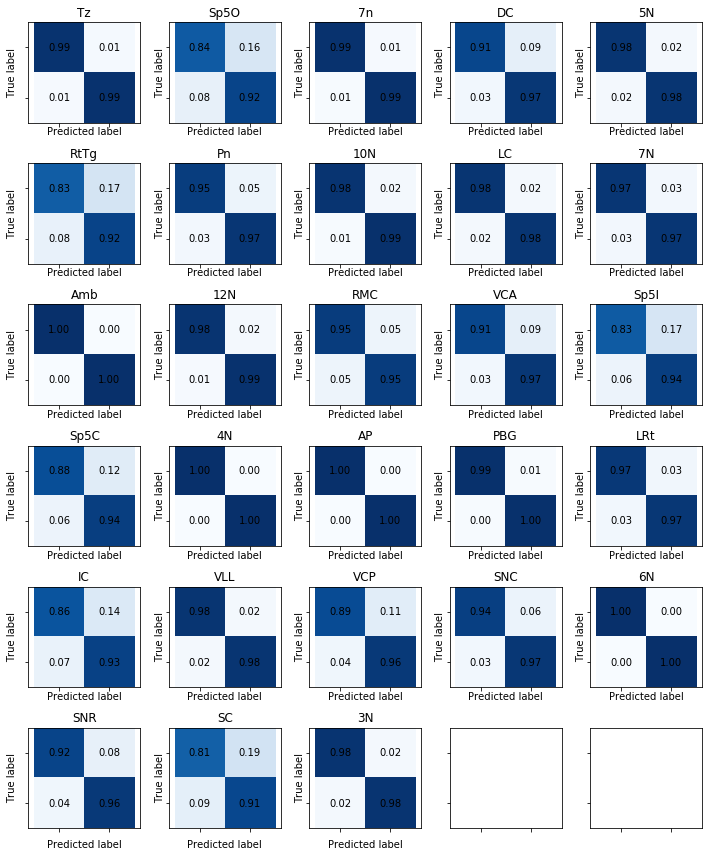

In [15]:
# Compute training accuracy

acc_all_structures = {}

ncols = 5
nrows = int(np.ceil(len(structures_found)/float(ncols)))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
axes = axes.flatten()

for i, structure in enumerate(structures_found):
        
    features_pos = training_features[structure]
    n_pos = len(features_pos)
    
#     if setting in [1, 3, 4, 5, 6, 7]:
#         neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
#     elif setting in [2, 10, 23, 24, 25, 26]:
#         neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]            
#         for surr_l in structures_found:
#             c = convert_to_surround_name(structure, margin=margin, suffix=surr_l)
#             if c in labels_found:
#                 neg_classes.append(c)
#     elif setting in [8,9,11]:
#         neg_classes = [structure + '_negative']
#     else:
#         sys.stderr.write('Setting is not recognized.\n')
#         raise

#     if setting in [1, 3, 4, 5, 6, 7]:
    if neg_composition == 'neg_has_only_surround_noclass':
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
#     elif setting in [2, 10, 23, 24, 25, 26]:
    elif neg_composition == 'neg_has_all_surround':
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
        for surr_s in structures_found:
            c = convert_to_surround_name(structure, margin=margin, suffix=surr_s)
            if c in labels_found:
                neg_classes.append(c)
#     elif setting in [8,9,11]:
    elif neg_composition == 'neg_has_everything_else':
        neg_classes = [structure + '_negative']
    else:
        raise Exception('Setting is not recognized.')
        
        
    features_neg = np.concatenate([training_features[neg_class] for neg_class in neg_classes])
#     neg_distances = np.concatenate([distances_to_structures[neg_class][label] for neg_class in neg_classes])
        
    n_neg = len(features_neg)
    
    train_data = np.r_[features_pos, features_neg]
    train_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
    clf = clf_allClasses[structure]
    
    probs = clf.predict_proba(train_data)[:, clf.classes_.tolist().index(1.)]
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in train_labels], soft=True)
    
    acc_all_structures[structure] = (n_pos*cm[0,0] + n_neg*cm[1,1])/(n_pos + n_neg)
    
    plot_confusion_matrix(cm, title='%(structure)s'% {'structure':structure},
                          labels=['',''],
#                           labels=[label, convert_to_surround_name(label)],
                         axis=axes[i])
#     plt.show();

plt.tight_layout()

In [16]:
print 'training accuracy:', np.mean(acc_all_structures.values())

training accuracy: 0.960697105946


In [ ]:
# Visualize training patches

patches = extract_patches_given_locations_multiple_sections(training_addresses['12N'][:10], 
                                                            location_or_grid_index='grid_index',
                                                            version='compressed')
display_images_in_grids(patches, nc=10)

# patches = extract_patches_given_locations_multiple_sections(training_addresses['12N_surround'][:10], 
#                                                             location_or_grid_index='grid_index',
#                                                             version='compressed')
# display_images_in_grids(patches, nc=10)

In [34]:
def patch_boxes_overlay_on(bg, downscale_factor, locs, patch_size, colors=None, stack=None, sec=None):
    """
    Assume bg has the specified downscale_factor.
    """

    if bg == 'original':
        bg = imread(DataManager.get_image_filepath(stack=stack, section=sec, version='compressed'))[::downscale_factor, ::downscale_factor]
       
    # viz = bg.copy()
    viz = gray2rgb(bg).copy()
    # need copy() because of this bug http://stackoverflow.com/a/31316516
    
    half_size = patch_size/2/downscale_factor
    if isinstance(locs[0], list):
        if colors is None:
            colors = random_colors(len(locs))
        for i, locs_oneColor in enumerate(locs):
            for x, y in locs_oneColor:
                x = x / downscale_factor
                y = y / downscale_factor
                cv2.rectangle(viz, (x-half_size, y-half_size), (x+half_size, y+half_size), colors[i], 2)
    else:
        if colors is None:
            colors = (255,0,0)
        for x, y in locs:
            x = x / downscale_factor
            y = y / downscale_factor
            cv2.rectangle(viz, (x-half_size, y-half_size), (x+half_size, y+half_size), colors, 2)
            
    return viz

In [35]:
# Visualize a patch in context

patch_size, stride, _, _ = get_default_gridspec('MD589')
grid_locations = grid_parameters_to_sample_locations(get_default_gridspec('MD589'))
viz = patch_boxes_overlay_on('original', 8, 
                       [grid_locations[44453]],
                      patch_size=patch_size,
                      stack='MD589',
                       sec=219)
display_image(viz)

/shared/MouseBrainAtlas/learning/tmp.jpg